In [15]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from OCD import *

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import time
import ot

rng = np.random.seed(0)

size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]


In [5]:
def find_optimal_map_sk_nd(X0, Y0, numItermax=100000, lambd=0.05):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  #G0 = ot.emd(a, b, M, numItermax=numItermax)
  Gs = ot.sinkhorn(a, b, M, lambd, numItermax=numItermax)

  index_X = np.argmax(Gs, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [6]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [7]:
import numpy as np

def sampling_nd(Np=1000, seed=0, n=2):
    #X0 = np.random.uniform(-1.,1.,Np)
    #Y0 = np.random.normal(0.0, 1.0, Np)
    #Y0 = Y0/4
    
    np.random.seed(seed)
    
    #x = np.random.uniform(-1.,1.,(Np,n)) #np.random.normal(0,1,(Np,n))
    ##np.random.shuffle(x)

    ##y = np.concatenate( [ np.random.normal(-1,0.2,(int(Np/2),n)), np.random.normal(1,0.3,(Np-int(Np/2),n)) ] )
    ##np.random.shuffle(y)

    #y = np.random.normal(0.0, 1.0, (Np,n))
    #y = y/4
    
    x = np.random.normal(0.0, 1.0, (Np,n))
    y = np.random.normal(1.0, 1.0, (Np,n))
    
    return x, y


In [30]:
import time

## Compute cost
eps = 0.1
nd = 2
Nps = [1000, 2000, 4000, 8000]#, 800, 1600, 3200]
emd_time = []
ocd_time = []
#Nps = [6400, 12800]
it = 0

for Np in Nps:
    print("Np="+str(Np))
    X0, Y0 = sampling_nd(Np, seed=it, n=nd)
    X00 = X0.copy(); Y00 = Y0.copy();
    
    start = time.time()
    X_emd, Y_emd = find_optimal_map_nd(X0, Y0)
    end = time.time()
    emd_time.append(end-start)
    
    print("EMD done")
    
    X0 = X00.copy(); Y0 = Y00.copy();
    start = time.time()
    eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3,0], nepss = 400, perc=0.9998)
    print("epsilon = ", eps0)
    dt = 0.1
    Nt = 200
    tol = 1e-4
    X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X0, Y0, dt=dt, Nt=Nt, sigma=eps0, tol=tol)
    #X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map(X0, Y0, dt=1e-3, Nt=1000, sigma=eps)
    end = time.time()
    ocd_time.append(end-start)
    print("OCD done")

Np=1000
EMD done
epsilon =  0.07712906117627992
OCD done
Np=2000
EMD done
epsilon =  0.05746434968715974
OCD done
Np=4000
EMD done
epsilon =  0.04432171342476086
OCD done
Np=8000
EMD done
epsilon =  0.03302151484968176
OCD done


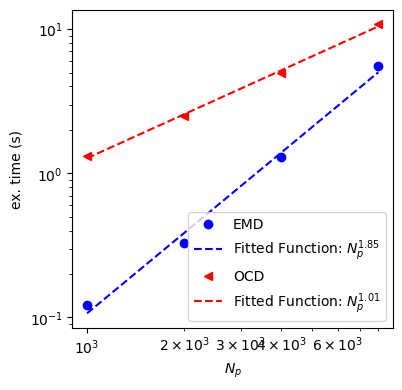

In [31]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

# Define the model
def model(f, a, b):
    return a * f * np.log(f) + b

def fit_f_log_f(x, y, xx):
    # Initial guess for the parameters
    initial_guess = [1, 1]
    
    # Fit the curve
    popt, pcov = curve_fit(model, x, y, p0=initial_guess)
    
    # Extract the optimal parameters
    slope, intercept = popt
    
    # Compute the fitted y values
    fitted_y = model(xx, *popt)
    
    #xlogx = x*np.log10(x)
    #slope, intercept, r_value, p_value, std_err = linregress(xlogx, y)
    
    #fitted_y = slope*xlogx + intercept
    return fitted_y, slope, intercept

def fit_log(x, y, xx):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * np.log10(xx))
    return fitted_y, slope_str
xx = np.linspace(Nps[0],Nps[-1],100)

fitted_emd, slope_emd = fit_log(Nps, emd_time, xx)
#fitted_sk, slope_sk = fit_log(Nps, sk_time, xx)
fitted_ocd, slope_ocd = fit_log(Nps, ocd_time, xx)
#fitted_ocd, a_opt, b_opt = fit_f_log_f(np.array(Nps), np.array(ocd_time) , xx)

fig, ax = plt.subplots();

ax.plot(Nps, emd_time,label="EMD", marker="o", linestyle="", color="blue")
ax.plot(xx, fitted_emd, label=r'Fitted Function: $N_p^{'+slope_emd+'}$', color='blue', linestyle="--")

#ax.plot(Nps, sk_time,label=r"Sinkhorn, $\lambda=0.1$", marker="o", linestyle="", color="green")
#ax.plot(xx, fitted_sk, label=r'Fitted Function: $N_p^{'+slope_sk+'}$', color='green', linestyle="--")

ax.plot(Nps, ocd_time, label="OCD", marker="<", linestyle="", color="red")
#ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p \log(N_p)$', color='red', linestyle="--")
ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p^{'+slope_ocd+'}$', color='red', linestyle="--")

ax.set_ylabel("ex. time (s)")
ax.set_xlabel(r"$N_p$")
ax.set_yscale('log')
ax.set_xscale('log')
#for axis in [ax.xaxis]:
#    axis.set_major_formatter(ScalarFormatter())
#    axis.set_minor_formatter(NullFormatter())
#ax.set_xticks(Nps,Nps)
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.legend()
fig.set_size_inches(size*cm*1.5, size*cm*1.5)
#fig.savefig(str(nd)+'d_time_norm0-1_norm1-1.pdf',format='pdf', bbox_inches="tight", dpi=300);

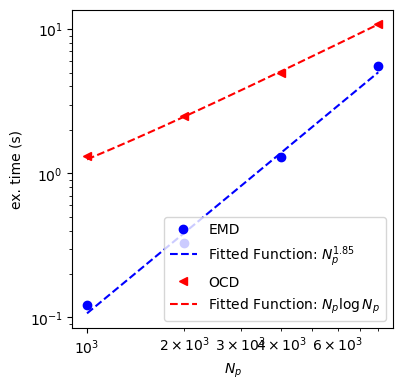

In [32]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib import pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

# Define the model N log N
def model(f, a, b):
    return a * f * np.log(f) + b

def fit_f_log_f(x, y, xx):
    initial_guess = [1, 1]
    popt, pcov = curve_fit(model, x, y, p0=initial_guess)
    a_opt, b_opt = popt
    fitted_y = model(xx, *popt)
    return fitted_y, a_opt, b_opt

def fit_log(x, y, xx):
    log_x = np.log10(x)
    log_y = np.log10(y)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'
    fitted_y = 10**(intercept + slope * np.log10(xx))
    return fitted_y, slope_str

# Fitting
xx = np.linspace(Nps[0], Nps[-1], 200)

fitted_emd, slope_emd = fit_log(Nps, emd_time, xx)
fitted_ocd, a_opt, b_opt = fit_f_log_f(np.array(Nps), np.array(ocd_time), xx)

# Plot
fig, ax = plt.subplots()

ax.plot(Nps, emd_time, label="EMD", marker="o", linestyle="", color="blue")
ax.plot(xx, fitted_emd, label=rf'Fitted Function: $N_p^{{{slope_emd}}}$', color='blue', linestyle="--")

ax.plot(Nps, ocd_time, label="OCD", marker="<", linestyle="", color="red")
ax.plot(xx, fitted_ocd, label=r'Fitted Function: $N_p \log N_p$', color='red', linestyle="--")

ax.set_ylabel("ex. time (s)")
ax.set_xlabel(r"$N_p$")
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()
fig.set_size_inches(size*cm*1.5, size*cm*1.5)
